In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv, GATv2Conv
from torch_geometric.data import Data, Batch
from torch_geometric.utils import dense_to_sparse
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [59]:
# Membaca dataset
df = pd.read_csv("harga_beras_premium.csv")
print(df.head(5))
print(df.shape)

      Tanggal      Komoditas             Provinsi    Harga
0  17/05/2022  Beras Premium  Nusa Tenggara Barat  10667.0
1  17/05/2022  Beras Premium     Sulawesi Selatan  10918.0
2  17/05/2022  Beras Premium             Bengkulu  11475.0
3  17/05/2022  Beras Premium               Banten  11163.0
4  17/05/2022  Beras Premium       D.I Yogyakarta  11240.0
(41648, 4)


In [60]:
# Mengecek missing values dari dataframe
null_values = df.isnull().sum()
null_values

Tanggal         0
Komoditas       0
Provinsi        0
Harga        4294
dtype: int64

In [61]:
# Menghapus missing value dari dataframe
df_cleaned = df.dropna()
print(df_cleaned.isnull().sum())
print(df_cleaned.shape)

Tanggal      0
Komoditas    0
Provinsi     0
Harga        0
dtype: int64
(37354, 4)


In [62]:
# Konversi kolom Tanggal ke datetime
df_cleaned['Tanggal'] = pd.to_datetime(df_cleaned['Tanggal'])
df_cleaned.head(5)

/tmp/ipykernel_7681/1040587474.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_cleaned['Tanggal'] = pd.to_datetime(df_cleaned['Tanggal'])
/tmp/ipykernel_7681/1040587474.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Tanggal'] = pd.to_datetime(df_cleaned['Tanggal'])


,Tanggal,Komoditas,Provinsi,Harga
0,2022-05-17,Beras Premium,Nusa Tenggara Barat,10667.0
1,2022-05-17,Beras Premium,Sulawesi Selatan,10918.0
2,2022-05-17,Beras Premium,Bengkulu,11475.0
3,2022-05-17,Beras Premium,Banten,11163.0
4,2022-05-17,Beras Premium,D.I Yogyakarta,11240.0


In [63]:
df_cleaned = df_cleaned.sort_values(['Tanggal', 'Provinsi'])

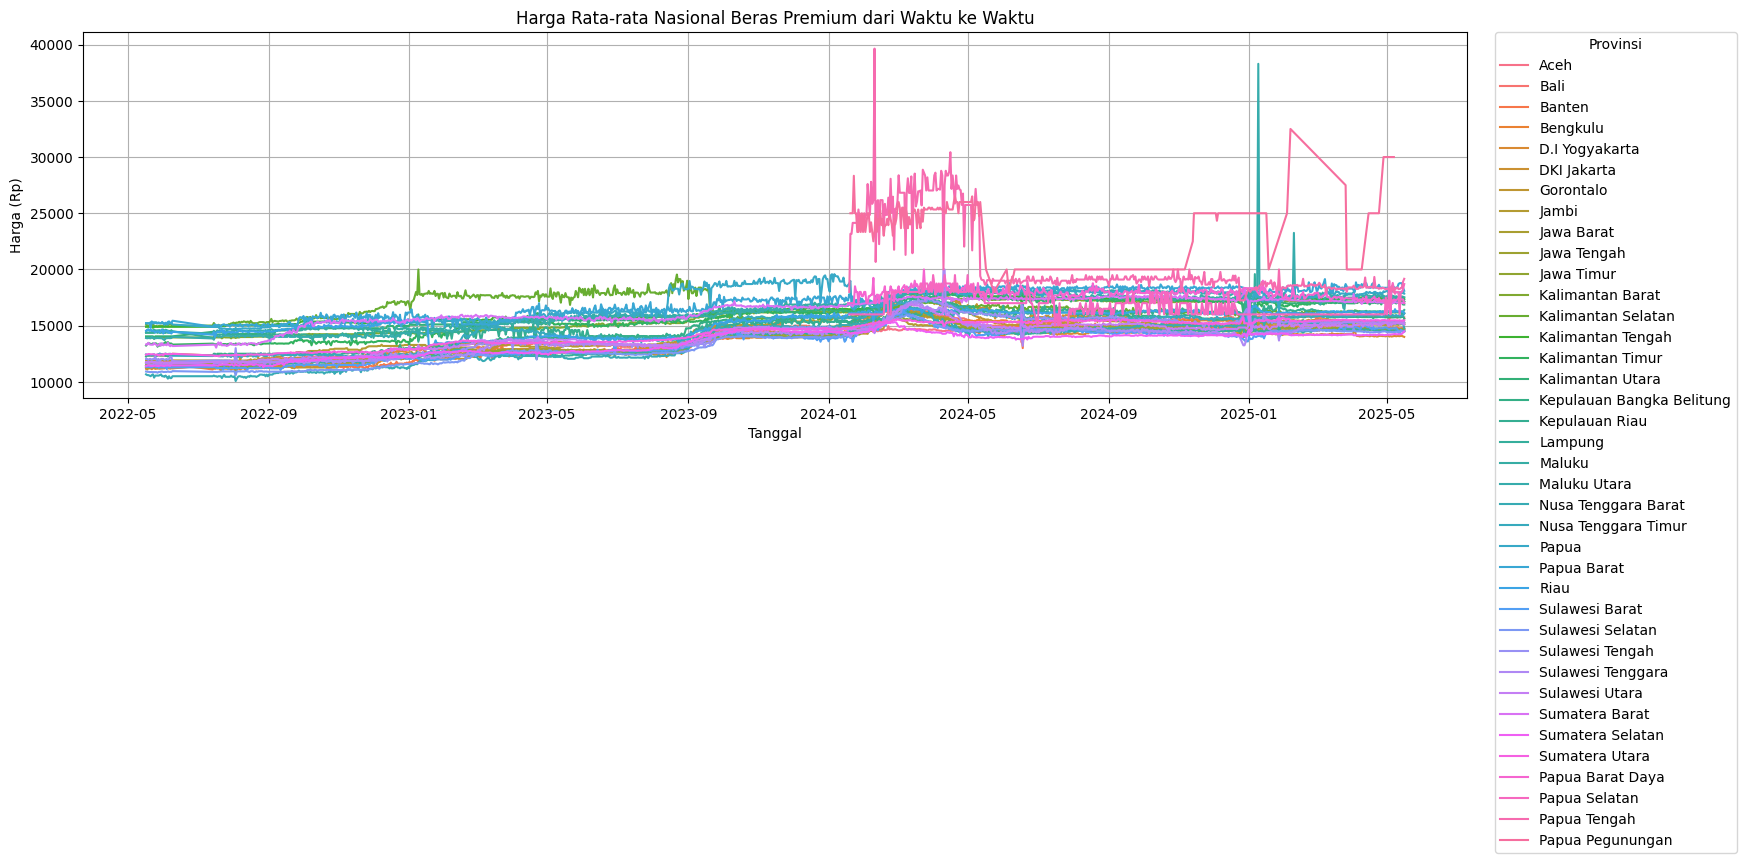

In [64]:
plt.figure(figsize=(20, 7))
sns.lineplot(x='Tanggal', y='Harga', data=df_cleaned, hue='Provinsi')
plt.title('Harga Rata-rata Nasional Beras Premium dari Waktu ke Waktu')
plt.xlabel('Tanggal')
plt.ylabel('Harga (Rp)')
plt.grid(True)
# Letakkan legenda di luar plot
plt.legend(title='Provinsi', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
# Sesuaikan layout agar legenda tidak terpotong
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()  # changed

                            count          mean          std      min  \
Provinsi                                                                
Aceh                       1055.0  13679.299526  1077.664954  11676.0   
Bali                       1059.0  14307.518414  1517.354063  11214.0   
Banten                     1056.0  13648.004735  1500.678516  11100.0   
Bengkulu                   1058.0  14144.027410  1463.772313  11219.0   
D.I Yogyakarta             1056.0  13472.887311  1302.248036  10767.0   
DKI Jakarta                1052.0  14270.831749  1634.025882  11960.0   
Gorontalo                  1061.0  14016.073516  1663.816871  11006.0   
Jambi                      1054.0  14172.085389  1127.123140  11818.0   
Jawa Barat                 1057.0  13701.751183  1377.086644  11490.0   
Jawa Tengah                1062.0  13775.455744  1332.665634  10667.0   
Jawa Timur                 1058.0  13593.981096  1239.233684  11189.0   
Kalimantan Barat           1058.0  15939.404537  12

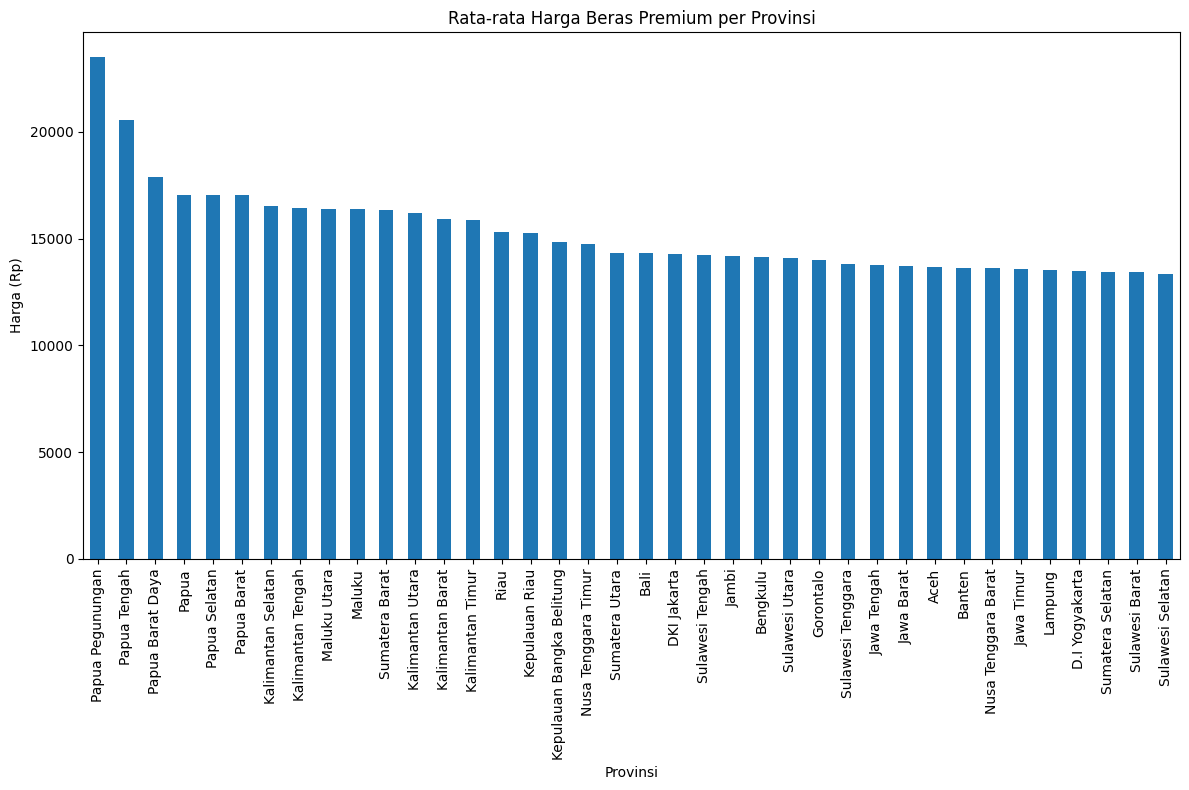

In [65]:
# Menampilkan statistik deskriptif dari data harga
stats_desc = df_cleaned.groupby('Provinsi')['Harga'].describe()
print(stats_desc)

# Mencari rata-rata harga per provinsi dan mengurutkannya
avg_price_by_province = df_cleaned.groupby('Provinsi')['Harga'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
avg_price_by_province.plot(kind='bar')
plt.title('Rata-rata Harga Beras Premium per Provinsi')
plt.ylabel('Harga (Rp)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

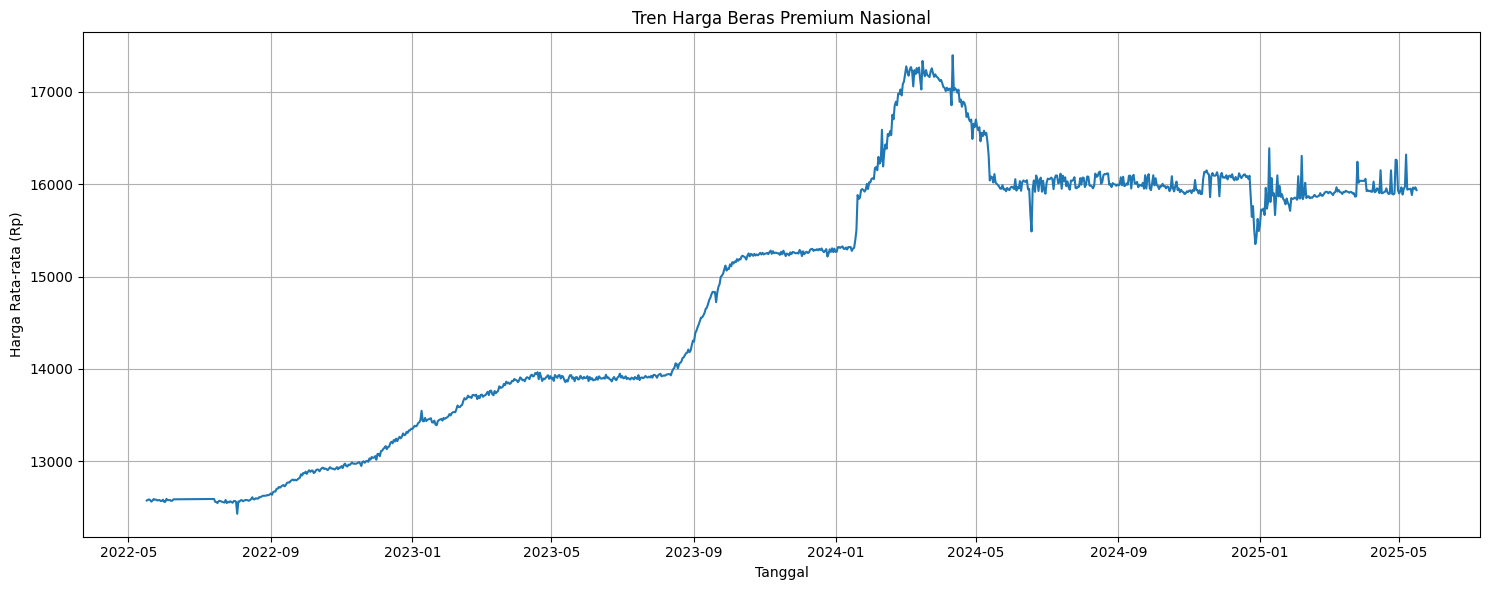

In [66]:
# Menganalisis tren harga per waktu (rata-rata nasional)
time_trend = df_cleaned.groupby('Tanggal')['Harga'].mean()
plt.figure(figsize=(15, 6))
plt.plot(time_trend.index, time_trend.values)
plt.title('Tren Harga Beras Premium Nasional')
plt.xlabel('Tanggal')
plt.ylabel('Harga Rata-rata (Rp)')
plt.grid(True)
plt.tight_layout()
plt.show()

Provinsi       Aceh     Bali   Banten  Bengkulu  D.I Yogyakarta  DKI Jakarta  \
Tanggal                                                                        
2022-05-17  11762.0  11396.0  11163.0   11475.0         11240.0      12333.0   
2022-05-18  11703.0  11407.0  11186.0   11475.0         11240.0      12333.0   
2022-05-19  11762.0  11407.0  11286.0   11475.0         11200.0      12333.0   
2022-05-20  11811.0  11407.0  11225.0   11475.0         11200.0      12333.0   
2022-05-21  11752.0  11407.0  11225.0   11475.0         11200.0      12333.0   

Provinsi    Gorontalo    Jambi  Jawa Barat  Jawa Tengah  ...  Papua Tengah  \
Tanggal                                                  ...                 
2022-05-17    11258.0  11909.0     11558.0      11456.0  ...       18000.0   
2022-05-18    11092.0  11909.0     11559.0      11431.0  ...       18000.0   
2022-05-19    11250.0  11909.0     11559.0      11384.0  ...       18000.0   
2022-05-20    11258.0  11909.0     11561.0      1

/tmp/ipykernel_7681/3340149772.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot_df = pivot_df.fillna(method='ffill').fillna(method='bfill')


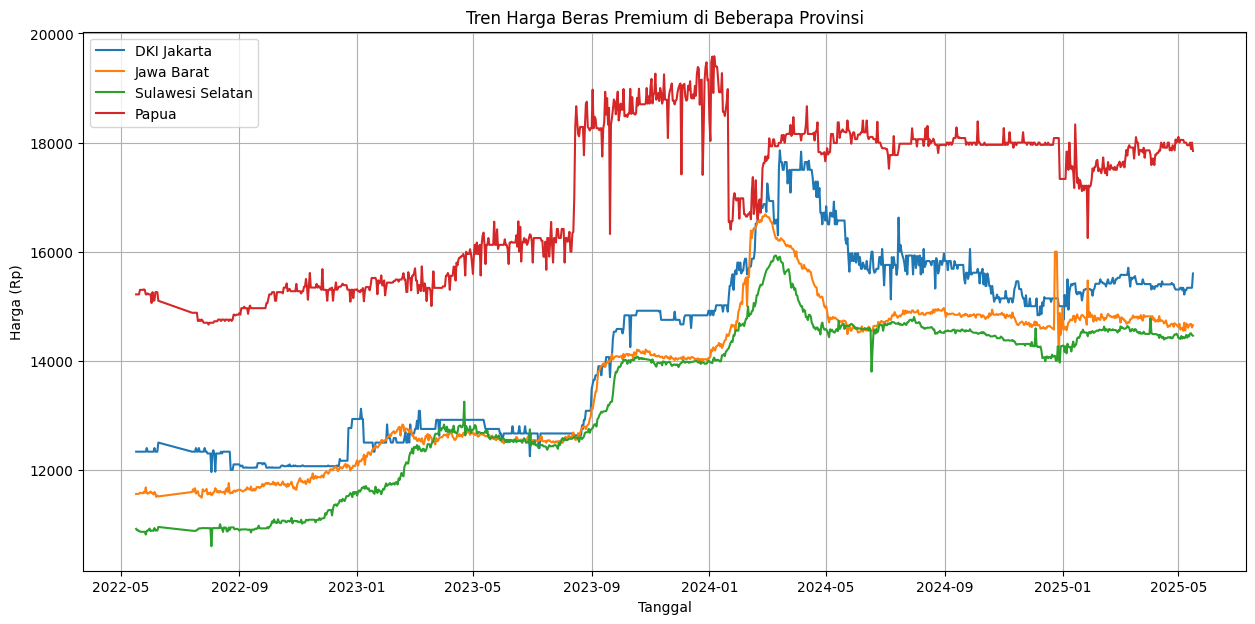

In [67]:
# Pivot data untuk mendapatkan format yang sesuai untuk analisis
pivot_df = df_cleaned.pivot_table(index='Tanggal', columns='Provinsi', values='Harga')

# Isi nilai yang hilang dengan metode forward fill dan backward fill
pivot_df = pivot_df.fillna(method='ffill').fillna(method='bfill')

# Tampilkan 5 baris pertama
print(pivot_df.head())

# Plot contoh beberapa provinsi untuk visualisasi
plt.figure(figsize=(15, 7))
for provinsi in ['DKI Jakarta', 'Jawa Barat', 'Sulawesi Selatan', 'Papua']:
    if provinsi in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[provinsi], label=provinsi)
plt.legend()
plt.title('Tren Harga Beras Premium di Beberapa Provinsi')
plt.xlabel('Tanggal')
plt.ylabel('Harga (Rp)')
plt.grid(True)
plt.show()

In [68]:
# Periksa dan tampilkan provinsi yang ada
provinsi_list = df_cleaned['Provinsi'].unique()
print(f"Jumlah provinsi: {len(provinsi_list)}")
print(provinsi_list)

Jumlah provinsi: 38
['Aceh' 'Bali' 'Banten' 'Bengkulu' 'D.I Yogyakarta' 'DKI Jakarta'
 'Gorontalo' 'Jambi' 'Jawa Barat' 'Jawa Tengah' 'Jawa Timur'
 'Kalimantan Barat' 'Kalimantan Selatan' 'Kalimantan Tengah'
 'Kalimantan Timur' 'Kalimantan Utara' 'Kepulauan Bangka Belitung'
 'Kepulauan Riau' 'Lampung' 'Maluku' 'Maluku Utara' 'Nusa Tenggara Barat'
 'Nusa Tenggara Timur' 'Papua' 'Papua Barat' 'Riau' 'Sulawesi Barat'
 'Sulawesi Selatan' 'Sulawesi Tengah' 'Sulawesi Tenggara' 'Sulawesi Utara'
 'Sumatera Barat' 'Sumatera Selatan' 'Sumatera Utara' 'Papua Barat Daya'
 'Papua Selatan' 'Papua Tengah' 'Papua Pegunungan']


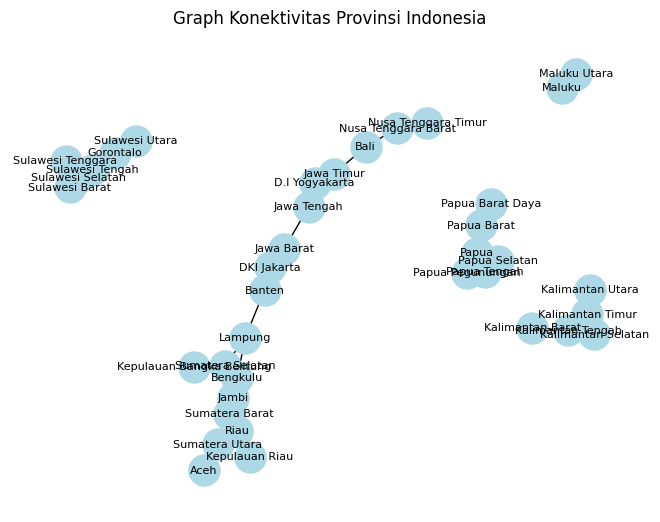

In [69]:
# Membuat graph dengan provinsi sebagai node
# Membuat edge berdasarkan kedekatan geografis
# Ini adalah contoh sederhana, Anda perlu menyesuaikannya dengan peta Indonesia yang sebenarnya

# Daftar tetangga untuk setiap provinsi (contoh sederhana)
# Format: {provinsi: [daftar_tetangga]}
neighbors = {
    'Aceh': ['Sumatera Utara'],
    'Sumatera Utara': ['Aceh', 'Sumatera Barat', 'Riau'],
    'Sumatera Barat': ['Sumatera Utara', 'Riau', 'Jambi'],
    'Riau': ['Sumatera Utara', 'Sumatera Barat', 'Jambi', 'Kepulauan Riau'],
    'Kepulauan Riau': ['Riau'],
    'Jambi': ['Sumatera Barat', 'Riau', 'Sumatera Selatan', 'Bengkulu'],
    'Bengkulu': ['Sumatera Barat', 'Jambi', 'Sumatera Selatan', 'Lampung'],
    'Sumatera Selatan': ['Jambi', 'Bengkulu', 'Lampung', 'Kepulauan Bangka Belitung'],
    'Kepulauan Bangka Belitung': ['Sumatera Selatan'],
    'Lampung': ['Bengkulu', 'Sumatera Selatan', 'Banten'],
    'DKI Jakarta': ['Banten', 'Jawa Barat'],
    'Jawa Barat': ['DKI Jakarta', 'Banten', 'Jawa Tengah'],
    'Banten': ['Lampung', 'DKI Jakarta', 'Jawa Barat'],
    'Jawa Tengah': ['Jawa Barat', 'D.I Yogyakarta', 'Jawa Timur'],
    'D.I Yogyakarta': ['Jawa Tengah', 'Jawa Timur'],
    'Jawa Timur': ['Jawa Tengah', 'D.I Yogyakarta', 'Bali'],
    'Bali': ['Jawa Timur', 'Nusa Tenggara Barat'],
    'Nusa Tenggara Barat': ['Bali', 'Nusa Tenggara Timur'],
    'Nusa Tenggara Timur': ['Nusa Tenggara Barat'],
    'Kalimantan Barat': ['Kalimantan Tengah'],
    'Kalimantan Tengah': ['Kalimantan Barat', 'Kalimantan Selatan', 'Kalimantan Timur'],
    'Kalimantan Selatan': ['Kalimantan Tengah', 'Kalimantan Timur'],
    'Kalimantan Timur': ['Kalimantan Tengah', 'Kalimantan Selatan', 'Kalimantan Utara'],
    'Kalimantan Utara': ['Kalimantan Timur'],
    'Sulawesi Utara': ['Gorontalo'],
    'Gorontalo': ['Sulawesi Utara', 'Sulawesi Tengah'],
    'Sulawesi Tengah': ['Gorontalo', 'Sulawesi Barat', 'Sulawesi Selatan', 'Sulawesi Tenggara'],
    'Sulawesi Barat': ['Sulawesi Tengah', 'Sulawesi Selatan'],
    'Sulawesi Selatan': ['Sulawesi Tengah', 'Sulawesi Barat', 'Sulawesi Tenggara'],
    'Sulawesi Tenggara': ['Sulawesi Tengah', 'Sulawesi Selatan'],
    'Maluku': ['Maluku Utara'],
    'Maluku Utara': ['Maluku'],
    'Papua Barat': ['Papua'],
    'Papua': ['Papua Barat', 'Papua Pegunungan', 'Papua Selatan', 'Papua Tengah'],
    'Papua Pegunungan': ['Papua', 'Papua Tengah'],
    'Papua Selatan': ['Papua', 'Papua Tengah'],
    'Papua Tengah': ['Papua', 'Papua Pegunungan', 'Papua Selatan'],
    'Papua Barat Daya': ['Papua Barat']
}

# Konversi daftar tetangga ke adjacency matrix
provinsi_array = np.array(provinsi_list)
N = len(provinsi_array)
adjacency_matrix = np.zeros((N, N))

# Mapping nama provinsi ke indeks
prov_to_idx = {prov: i for i, prov in enumerate(provinsi_array)}

# Isi adjacency matrix
for prov, neighbors_list in neighbors.items():
    if prov in prov_to_idx:
        i = prov_to_idx[prov]
        for neighbor in neighbors_list:
            if neighbor in prov_to_idx:
                j = prov_to_idx[neighbor]
                adjacency_matrix[i, j] = 1
                adjacency_matrix[j, i] = 1  # Undirected graph

# Konversi adjacency matrix ke edge_index untuk PyTorch Geometric
edge_index, _ = dense_to_sparse(torch.tensor(adjacency_matrix))

# Visualisasi graph untuk memastikan konektivitas yang benar
G = nx.from_numpy_array(adjacency_matrix)
nx.draw(G, with_labels=True, labels={i: prov for i, prov in enumerate(provinsi_array)}, 
        node_size=500, node_color='lightblue', font_size=8)
plt.title("Graph Konektivitas Provinsi Indonesia")
plt.show()

In [70]:
# Normalisasi data harga beras
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(pivot_df.values)
normalized_df = pd.DataFrame(normalized_data, index=pivot_df.index, columns=pivot_df.columns)

# Fungsi untuk membuat window data untuk time series
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 30):  # 30 hari prediksi ke depan
        x = data[i:(i + seq_length)]
        y = data[(i + seq_length):(i + seq_length + 30)]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Gunakan 14 hari sebelumnya untuk memprediksi 30 hari ke depan
sequence_length = 14
X, y = create_sequences(normalized_data, sequence_length)

# Split data menjadi train (80%) dan test (20%)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Konversi ke tensor PyTorch
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [71]:
# Cek bentuk data
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Normalisasi data harga beras
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(pivot_df.values)

# Fungsi untuk membuat window data untuk time series yang benar
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 30):  # 30 hari prediksi ke depan
        x = data[i:(i + seq_length)]
        y = data[(i + seq_length):(i + seq_length + 30)]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Gunakan 14 hari sebelumnya untuk memprediksi 30 hari ke depan
sequence_length = 14
X, y = create_sequences(normalized_data, sequence_length)

# Split data menjadi train (80%) dan test (20%)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Konversi ke tensor PyTorch
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

print(f"X_train shape after preparation: {X_train.shape}")  # Seharusnya [num_samples, seq_length, num_nodes]
print(f"y_train shape after preparation: {y_train.shape}")  # Seharusnya [num_samples, out_seq_length, num_nodes]

X_train shape: torch.Size([814, 14, 38])
y_train shape: torch.Size([814, 30, 38])
X_train shape after preparation: torch.Size([814, 14, 38])
y_train shape after preparation: torch.Size([814, 30, 38])


In [72]:
import optuna
from optuna.trial import Trial
import time

# Definisi fungsi objective untuk Optuna
def objective(trial: Trial):
    # Define hyperparameters to optimize
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    n_gnn_layers = trial.suggest_int('n_gnn_layers', 1, 3)
    lstm_layers = trial.suggest_int('lstm_layers', 1, 2)
    
    # Definisi model dengan parameter yang diusulkan oleh Optuna
    class TunedSpatioTemporalGNN(nn.Module):
        def __init__(self, num_nodes, seq_length, hidden_dim, dropout_rate, n_gnn_layers, lstm_layers, out_seq_length=30):
            super(TunedSpatioTemporalGNN, self).__init__()
            
            # Layer untuk transformasi awal
            self.input_fc = nn.Linear(seq_length, hidden_dim)
            
            # Layer GNN untuk menangkap hubungan spasial antar provinsi
            self.gnn_layers = nn.ModuleList()
            for i in range(n_gnn_layers):
                self.gnn_layers.append(GCNConv(hidden_dim, hidden_dim))
            
            # Dropout layers
            self.dropout = nn.Dropout(dropout_rate)
            
            # Layer untuk menangkap temporal dependency
            self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=lstm_layers, batch_first=True)
            
            # Layer output untuk prediksi
            self.fc = nn.Linear(hidden_dim, out_seq_length)
            
            self.num_nodes = num_nodes
            self.hidden_dim = hidden_dim
            
        def forward(self, x, edge_index):
            batch_size = x.size(0)
            
            # Reshape untuk memproses setiap batch satu per satu
            x = x.transpose(1, 2)
            
            # Proses semua batch sekaligus
            batch_outputs = []
            
            for b in range(batch_size):
                # Ambil data untuk batch ini: [num_nodes, seq_length]
                x_b = x[b]
                
                # Transformasi input sebelum GNN
                node_feats = self.input_fc(x_b)  # [num_nodes, hidden_dim]
                node_feats = self.dropout(node_feats)
                
                # Aplikasikan GNN layers
                h = node_feats
                for gnn in self.gnn_layers:
                    h = gnn(h, edge_index)
                    h = torch.relu(h)
                    h = self.dropout(h)
                
                # Reshape untuk LSTM: setiap node sebagai sequence
                h = h.unsqueeze(1)  # [num_nodes, 1, hidden_dim]
                
                # Process temporal dependencies
                lstm_out, _ = self.lstm(h)  # [num_nodes, 1, hidden_dim]
                lstm_out = self.dropout(lstm_out)
                
                # Final prediction
                pred = self.fc(lstm_out.squeeze(1))  # [num_nodes, out_seq_length]
                
                batch_outputs.append(pred)
            
            # Stack all batch outputs and transpose to match expected shape
            outputs = torch.stack(batch_outputs)  # [batch_size, num_nodes, out_seq_length]
            outputs = outputs.transpose(1, 2)  # [batch_size, out_seq_length, num_nodes]
            
            return outputs
    
    # Inisialisasi model dengan parameter dari Optuna trial
    model = TunedSpatioTemporalGNN(
        num_nodes=num_nodes,
        seq_length=sequence_length,
        hidden_dim=hidden_dim,
        dropout_rate=dropout_rate,
        n_gnn_layers=n_gnn_layers,
        lstm_layers=lstm_layers,
        out_seq_length=30
    )
    
    # Loss function dan optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), 
                          lr=learning_rate,
                          weight_decay=weight_decay)
    
    # Split data untuk validasi
    val_ratio = 0.2
    train_samples = int(len(X_train) * (1 - val_ratio))
    X_train_subset = X_train[:train_samples]
    y_train_subset = y_train[:train_samples]
    X_val = X_train[train_samples:]
    y_val = y_train[train_samples:]
    
    # Parameter training
    n_epochs = 50  # Kurangi epoch untuk mempercepat tuning
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0
    
    # Training loop
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X_train_subset, edge_index)
        loss = criterion(outputs, y_train_subset)
        
        loss.backward()
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val, edge_index)
            val_loss = criterion(val_outputs, y_val)
        
        # Report untuk pruning
        trial.report(val_loss.item(), epoch)
        
        # Periksa apakah sebaiknya trial ini dihentikan
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    return best_val_loss.item()

In [73]:
# Buat study Optuna dan jalankan optimasi
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=20)  # Jumlah trial dapat disesuaikan

[I 2025-06-11 16:48:48,034] A new study created in memory with name: no-name-9141c3c0-93d7-4cb4-b5c7-c6eecf505cf0
[I 2025-06-11 16:51:46,461] Trial 0 finished with value: 0.04192325845360756 and parameters: {'hidden_dim': 256, 'learning_rate': 0.00027270439729488766, 'dropout_rate': 0.09893458063097094, 'weight_decay': 6.639554359524217e-05, 'n_gnn_layers': 3, 'lstm_layers': 1}. Best is trial 0 with value: 0.04192325845360756.


Early stopping at epoch 38


[I 2025-06-11 16:55:51,688] Trial 1 finished with value: 0.042341653257608414 and parameters: {'hidden_dim': 256, 'learning_rate': 0.00015575093422017305, 'dropout_rate': 0.3044109393999488, 'weight_decay': 1.629731089706531e-05, 'n_gnn_layers': 3, 'lstm_layers': 1}. Best is trial 0 with value: 0.04192325845360756.
[I 2025-06-11 16:59:32,939] Trial 2 finished with value: 0.03707480803132057 and parameters: {'hidden_dim': 256, 'learning_rate': 0.000184713169787737, 'dropout_rate': 0.11749588407099926, 'weight_decay': 1.6920113508745454e-05, 'n_gnn_layers': 1, 'lstm_layers': 2}. Best is trial 2 with value: 0.03707480803132057.
[I 2025-06-11 17:00:49,409] Trial 3 finished with value: 0.41425561904907227 and parameters: {'hidden_dim': 64, 'learning_rate': 0.000119471172893472, 'dropout_rate': 0.34789275546987186, 'weight_decay': 1.5207113086346264e-05, 'n_gnn_layers': 1, 'lstm_layers': 1}. Best is trial 2 with value: 0.03707480803132057.
[I 2025-06-11 17:02:12,472] Trial 4 finished with va

Early stopping at epoch 27


[I 2025-06-11 17:02:15,589] Trial 5 pruned. 
[I 2025-06-11 17:02:18,335] Trial 6 pruned. 
[I 2025-06-11 17:02:21,415] Trial 7 pruned. 
[I 2025-06-11 17:03:10,705] Trial 8 finished with value: 0.03968249633908272 and parameters: {'hidden_dim': 128, 'learning_rate': 0.0020857197436579215, 'dropout_rate': 0.1899137780637718, 'weight_decay': 3.489792073445558e-05, 'n_gnn_layers': 2, 'lstm_layers': 1}. Best is trial 2 with value: 0.03707480803132057.


Early stopping at epoch 20


[I 2025-06-11 17:04:43,893] Trial 9 finished with value: 0.039421793073415756 and parameters: {'hidden_dim': 128, 'learning_rate': 0.0006151738297990656, 'dropout_rate': 0.2575393865841277, 'weight_decay': 1.1587426462998354e-05, 'n_gnn_layers': 2, 'lstm_layers': 1}. Best is trial 2 with value: 0.03707480803132057.


Early stopping at epoch 37
Early stopping at epoch 37


[I 2025-06-11 17:07:24,111] Trial 10 finished with value: 0.03273501619696617 and parameters: {'hidden_dim': 256, 'learning_rate': 0.009212805762191587, 'dropout_rate': 0.028674432258502136, 'weight_decay': 0.0001289541004527316, 'n_gnn_layers': 1, 'lstm_layers': 2}. Best is trial 10 with value: 0.03273501619696617.


Early stopping at epoch 37


[I 2025-06-11 17:10:07,420] Trial 11 finished with value: 0.03235848620533943 and parameters: {'hidden_dim': 256, 'learning_rate': 0.00942333341318816, 'dropout_rate': 0.01096461813527274, 'weight_decay': 0.00012450083651361843, 'n_gnn_layers': 1, 'lstm_layers': 2}. Best is trial 11 with value: 0.03235848620533943.


Early stopping at epoch 27


[I 2025-06-11 17:12:06,114] Trial 12 finished with value: 0.03266539424657822 and parameters: {'hidden_dim': 256, 'learning_rate': 0.009561238192404734, 'dropout_rate': 0.012022114414022796, 'weight_decay': 0.0001880153173994017, 'n_gnn_layers': 1, 'lstm_layers': 2}. Best is trial 11 with value: 0.03235848620533943.
[I 2025-06-11 17:15:36,648] Trial 13 finished with value: 0.03367719054222107 and parameters: {'hidden_dim': 256, 'learning_rate': 0.009569347158334815, 'dropout_rate': 0.01832299928670831, 'weight_decay': 0.00017283884655691566, 'n_gnn_layers': 2, 'lstm_layers': 2}. Best is trial 11 with value: 0.03235848620533943.


Early stopping at epoch 40
Early stopping at epoch 15


[I 2025-06-11 17:16:20,645] Trial 14 finished with value: 0.03869958221912384 and parameters: {'hidden_dim': 256, 'learning_rate': 0.004256638303850339, 'dropout_rate': 0.09816733613427964, 'weight_decay': 0.00021439285872857142, 'n_gnn_layers': 1, 'lstm_layers': 2}. Best is trial 11 with value: 0.03235848620533943.
[I 2025-06-11 17:17:57,972] Trial 15 finished with value: 0.033454302698373795 and parameters: {'hidden_dim': 256, 'learning_rate': 0.004503049852825816, 'dropout_rate': 0.008530690965695864, 'weight_decay': 7.739406400337892e-05, 'n_gnn_layers': 1, 'lstm_layers': 2}. Best is trial 11 with value: 0.03235848620533943.


Early stopping at epoch 31


[I 2025-06-11 17:18:01,964] Trial 16 pruned. 
[I 2025-06-11 17:18:05,472] Trial 17 pruned. 
[I 2025-06-11 17:18:09,396] Trial 18 pruned. 
[I 2025-06-11 17:18:37,646] Trial 19 finished with value: 0.040946342051029205 and parameters: {'hidden_dim': 128, 'learning_rate': 0.006283454701240139, 'dropout_rate': 0.4852062653042358, 'weight_decay': 0.00010467357028570564, 'n_gnn_layers': 1, 'lstm_layers': 2}. Best is trial 11 with value: 0.03235848620533943.


Early stopping at epoch 15


In [74]:
# Tampilkan hasil terbaik
best_trial = study.best_trial
print(f"\nBest trial: {best_trial.number}")
print(f"Value: {best_trial.value:.4f}")
print("Params:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")


Best trial: 11
Value: 0.0324
Params:
  hidden_dim: 256
  learning_rate: 0.00942333341318816
  dropout_rate: 0.01096461813527274
  weight_decay: 0.00012450083651361843
  n_gnn_layers: 1
  lstm_layers: 2


In [75]:
# Visualisasi hasil (opsional, jika visualisasi tersedia)
try:
    # Plot optimization history
    optuna.visualization.plot_optimization_history(study)
    
    # Plot parameter importance
    optuna.visualization.plot_param_importances(study)
    
    # Plot intermediate values
    optuna.visualization.plot_intermediate_values(study)
except:
    print("Visualization not available")

# Training model dengan parameter terbaik dari optuna
print("\nTraining model dengan parameter terbaik...")

Visualization not available

Training model dengan parameter terbaik...


In [76]:
# Definisi model final menggunakan parameter terbaik
class FinalSpatioTemporalGNN(nn.Module):
    def __init__(self, num_nodes, seq_length, hidden_dim, dropout_rate, n_gnn_layers, lstm_layers, out_seq_length=30):
        super(FinalSpatioTemporalGNN, self).__init__()
        
        # Layer untuk transformasi awal
        self.input_fc = nn.Linear(seq_length, hidden_dim)
        
        # Layer GNN untuk menangkap hubungan spasial antar provinsi
        self.gnn_layers = nn.ModuleList()
        for i in range(n_gnn_layers):
            self.gnn_layers.append(GCNConv(hidden_dim, hidden_dim))
        
        # Dropout layers
        self.dropout = nn.Dropout(dropout_rate)
        
        # Layer untuk menangkap temporal dependency
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=lstm_layers, batch_first=True)
        
        # Layer output untuk prediksi
        self.fc = nn.Linear(hidden_dim, out_seq_length)
        
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        
    def forward(self, x, edge_index):
        batch_size = x.size(0)
        
        # Reshape untuk memproses setiap batch satu per satu
        x = x.transpose(1, 2)
        
        # Proses semua batch sekaligus
        batch_outputs = []
        
        for b in range(batch_size):
            # Ambil data untuk batch ini: [num_nodes, seq_length]
            x_b = x[b]
            
            # Transformasi input sebelum GNN
            node_feats = self.input_fc(x_b)  # [num_nodes, hidden_dim]
            node_feats = self.dropout(node_feats)
            
            # Aplikasikan GNN layers
            h = node_feats
            for gnn in self.gnn_layers:
                h = gnn(h, edge_index)
                h = torch.relu(h)
                h = self.dropout(h)
            
            # Reshape untuk LSTM: setiap node sebagai sequence
            h = h.unsqueeze(1)  # [num_nodes, 1, hidden_dim]
            
            # Process temporal dependencies
            lstm_out, _ = self.lstm(h)  # [num_nodes, 1, hidden_dim]
            lstm_out = self.dropout(lstm_out)
            
            # Final prediction
            pred = self.fc(lstm_out.squeeze(1))  # [num_nodes, out_seq_length]
            
            batch_outputs.append(pred)
        
        # Stack all batch outputs and transpose to match expected shape
        outputs = torch.stack(batch_outputs)  # [batch_size, num_nodes, out_seq_length]
        outputs = outputs.transpose(1, 2)  # [batch_size, out_seq_length, num_nodes]
        
        return outputs


In [77]:
# Inisialisasi final model dengan parameter terbaik
final_model = FinalSpatioTemporalGNN(
    num_nodes=num_nodes,
    seq_length=sequence_length,
    hidden_dim=best_trial.params['hidden_dim'],
    dropout_rate=best_trial.params['dropout_rate'],
    n_gnn_layers=best_trial.params['n_gnn_layers'],
    lstm_layers=best_trial.params['lstm_layers'],
    out_seq_length=30
)

In [78]:
# Loss function dan optimizer
criterion = nn.MSELoss()
final_optimizer = optim.Adam(
    final_model.parameters(), 
    lr=best_trial.params['learning_rate'],
    weight_decay=best_trial.params['weight_decay']
)

In [79]:
# Training loop
num_epochs = 100  # Gunakan lebih banyak epoch untuk model final
for epoch in range(num_epochs):
    final_model.train()
    final_optimizer.zero_grad()
    
    outputs = final_model(X_train, edge_index)
    loss = criterion(outputs, y_train)
    
    loss.backward()
    final_optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.0470
Epoch [20/100], Loss: 0.0242
Epoch [30/100], Loss: 0.0210
Epoch [40/100], Loss: 0.0201
Epoch [50/100], Loss: 0.0209
Epoch [60/100], Loss: 0.0189
Epoch [70/100], Loss: 0.0180
Epoch [80/100], Loss: 0.0186
Epoch [90/100], Loss: 0.0176
Epoch [100/100], Loss: 0.0177


In [80]:
# Evaluasi model final
final_model.eval()
with torch.no_grad():
    final_predictions = final_model(X_test, edge_index)
    final_loss = criterion(final_predictions, y_test)

y_pred_final = final_predictions.detach().numpy()
y_true_final = y_test.numpy()

# Flatten untuk mengevaluasi keseluruhan performa
y_pred_flat_final = y_pred_final.reshape(-1)
y_true_flat_final = y_true_final.reshape(-1)

final_rmse = np.sqrt(mean_squared_error(y_true_flat_final, y_pred_flat_final))
final_mae = mean_absolute_error(y_true_flat_final, y_pred_flat_final)
final_r2 = r2_score(y_true_flat_final, y_pred_flat_final)

print("\nFinal Model Performance:")
print(f"Test Loss: {final_loss.item():.4f}")
print(f"RMSE: {final_rmse:.4f}")
print(f"MAE: {final_mae:.4f}")
print(f"R² Score: {final_r2:.4f}")


Final Model Performance:
Test Loss: 0.0369
RMSE: 0.1920
MAE: 0.1417
R² Score: 0.1846


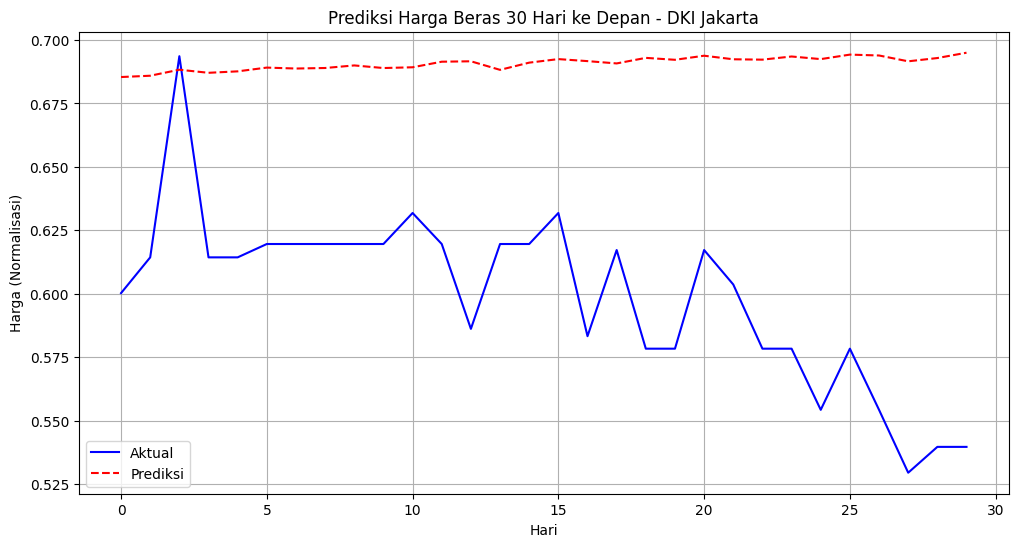

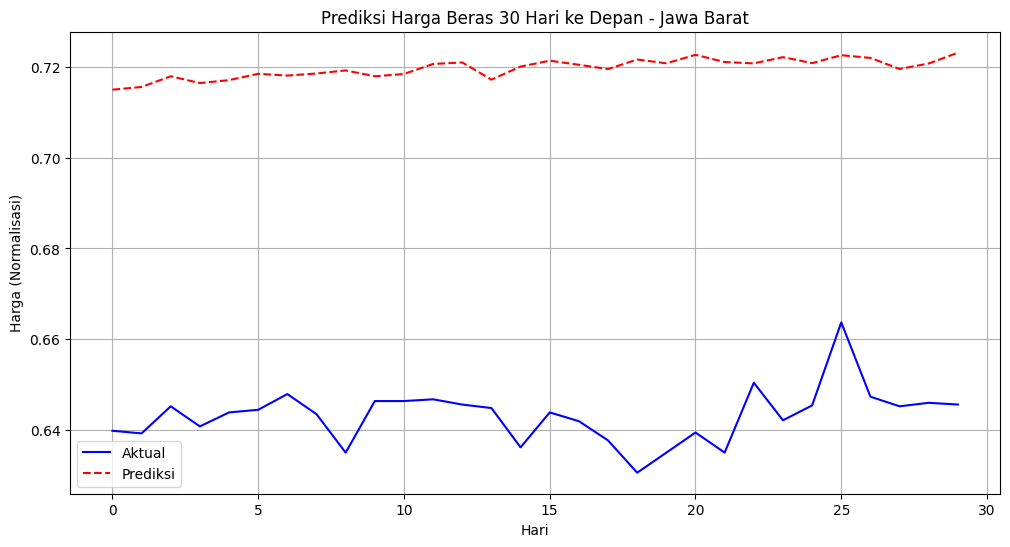

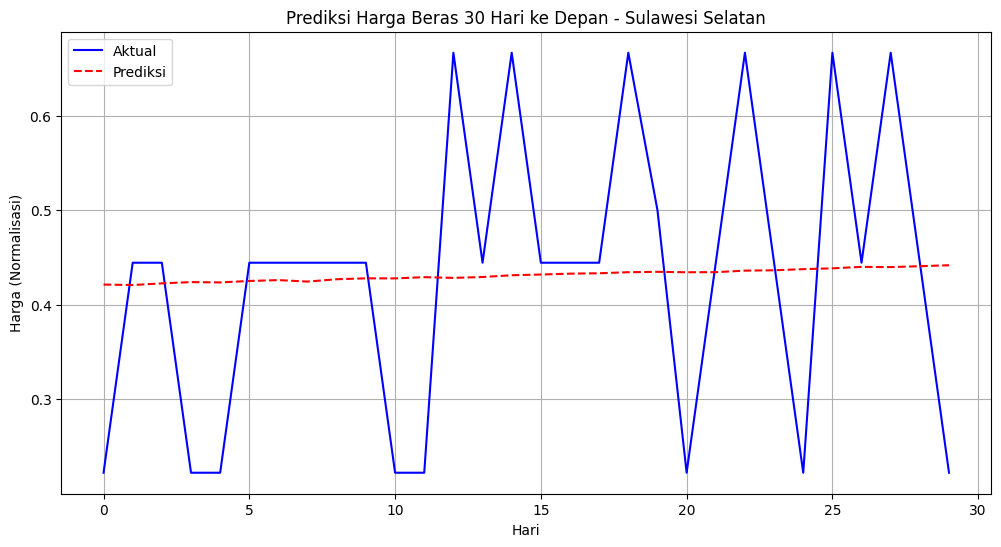

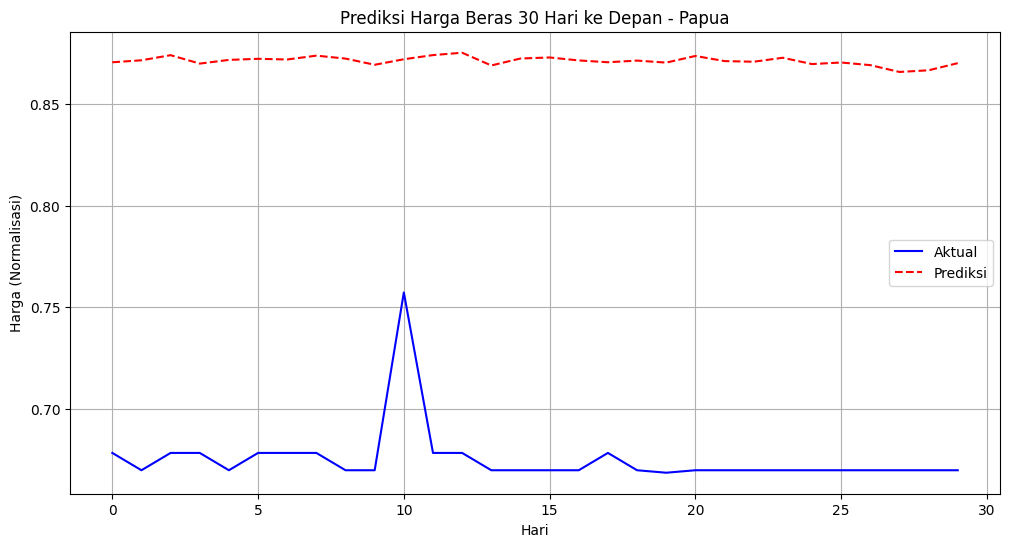

In [81]:
# Visualisasi hasil prediksi
sample_idx = 0
provinces_to_visualize = ['DKI Jakarta', 'Jawa Barat', 'Sulawesi Selatan', 'Papua']

for province in provinces_to_visualize:
    if province in provinsi_list:
        prov_idx = np.where(provinsi_array == province)[0][0]
        
        actual_prices = y_true_final[sample_idx, :, prov_idx]
        predicted_prices = y_pred_final[sample_idx, :, prov_idx]
        
        plt.figure(figsize=(12, 6))
        plt.plot(range(30), actual_prices, 'b-', label='Aktual')
        plt.plot(range(30), predicted_prices, 'r--', label='Prediksi')
        plt.title(f'Prediksi Harga Beras 30 Hari ke Depan - {province}')
        plt.xlabel('Hari')
        plt.ylabel('Harga (Normalisasi)')
        plt.legend()
        plt.grid(True)
        plt.show()

In [82]:
# class SpatioTemporalGNN(nn.Module):
#     def __init__(self, num_nodes, seq_length, hidden_dim=64, out_seq_length=30):
#         super(SpatioTemporalGNN, self).__init__()
        
#         # Layer untuk transformasi awal
#         self.input_fc = nn.Linear(seq_length, hidden_dim)
        
#         # Layer GNN untuk menangkap hubungan spasial antar provinsi
#         self.gnn1 = GCNConv(hidden_dim, hidden_dim)
#         self.gnn2 = GCNConv(hidden_dim, hidden_dim)
        
#         # Layer untuk menangkap temporal dependency
#         self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        
#         # Layer output untuk prediksi
#         self.fc = nn.Linear(hidden_dim, out_seq_length)
        
#         self.num_nodes = num_nodes
#         self.hidden_dim = hidden_dim
        
#     def forward(self, x, edge_index):
#         batch_size = x.size(0)
        
#         # Reshape untuk memproses setiap batch satu per satu
#         # x shape: [batch_size, seq_length, num_nodes]
#         x = x.transpose(1, 2)
        
#         # Proses semua batch sekaligus
#         batch_outputs = []
        
#         for b in range(batch_size):
#             # Ambil data untuk batch ini: [num_nodes, seq_length]
#             x_b = x[b]
            
#             # Transformasi input sebelum GNN
#             node_feats = self.input_fc(x_b)  # [num_nodes, hidden_dim]
            
#             # Aplikasikan GNN layers
#             h = self.gnn1(node_feats, edge_index)
#             h = torch.relu(h)
#             h = self.gnn2(h, edge_index)
#             h = torch.relu(h)  # [num_nodes, hidden_dim]
            
#             # Reshape untuk LSTM: setiap node sebagai sequence
#             h = h.unsqueeze(1)  # [num_nodes, 1, hidden_dim]
            
#             # Process temporal dependencies
#             lstm_out, _ = self.lstm(h)  # [num_nodes, 1, hidden_dim]
            
#             # Final prediction
#             pred = self.fc(lstm_out.squeeze(1))  # [num_nodes, out_seq_length]
            
#             batch_outputs.append(pred)
        
#         # Stack all batch outputs and transpose to match expected shape
#         outputs = torch.stack(batch_outputs)  # [batch_size, num_nodes, out_seq_length]
#         outputs = outputs.transpose(1, 2)  # [batch_size, out_seq_length, num_nodes]
        
#         return outputs

In [83]:
# # Inisialisasi parameter
# hidden_dim = 64
# num_nodes = len(provinsi_list)
# num_epochs = 100
# learning_rate = 0.001

# # Inisialisasi model dengan versi yang sudah diperbaiki
# model = SpatioTemporalGNN(num_nodes, sequence_length, hidden_dim, out_seq_length=30)

# # Loss function dan optimizer
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Training loop tanpa batching
# train_losses = []

# # Cek bentuk data
# print(f"X_train shape: {X_train.shape}")
# print(f"y_train shape: {y_train.shape}")

# for epoch in range(num_epochs):
#     model.train()
    
#     optimizer.zero_grad()
    
#     # Forward pass dengan semua data
#     outputs = model(X_train, edge_index)
    
#     # Calculate loss
#     loss = criterion(outputs, y_train)
    
#     # Backward pass and optimize
#     loss.backward()
#     optimizer.step()
    
#     train_losses.append(loss.item())
    
#     if (epoch + 1) % 10 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# # Plot training loss
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses)
# plt.title('Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.grid(True)
# plt.show()

In [84]:
# # Evaluasi model
# model.eval()
# with torch.no_grad():
#     test_predictions = model(X_test, edge_index)
#     test_loss = criterion(test_predictions, y_test)
#     print(f"Test Loss: {test_loss.item():.4f}")
    
# # Inverse transform untuk mendapatkan nilai harga sebenarnya
# # Reshape prediksi dan ground truth untuk inverse transform
# y_pred = test_predictions.detach().numpy()
# y_true = y_test.numpy()

# # Flatten untuk mengevaluasi keseluruhan performa
# y_pred_flat = y_pred.reshape(-1)
# y_true_flat = y_true.reshape(-1)

# # Menghitung metrik evaluasi (dalam skala normalisasi)
# rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
# mae = mean_absolute_error(y_true_flat, y_pred_flat)
# r2 = r2_score(y_true_flat, y_pred_flat)

# print(f"RMSE (normalized): {rmse:.4f}")
# print(f"MAE (normalized): {mae:.4f}")
# print(f"R² Score: {r2:.4f}")

In [85]:
# # Visualisasi prediksi untuk beberapa provinsi pilihan
# # Ambil satu sampel dari test set
# sample_idx = 0

# # Provinsi yang akan divisualisasi
# provinces_to_visualize = ['DKI Jakarta', 'Jawa Barat', 'Sulawesi Selatan', 'Papua']

# # Denormalisasi data untuk visualisasi provinsi tertentu
# for province in provinces_to_visualize:
#     if province in provinsi_list:
#         prov_idx = np.where(provinsi_array == province)[0][0]
        
#         # Ambil data untuk provinsi ini dari satu sampel
#         actual_prices = y_true[sample_idx, :, prov_idx]
#         predicted_prices = y_pred[sample_idx, :, prov_idx]
        
#         plt.figure(figsize=(12, 6))
#         plt.plot(range(30), actual_prices, 'b-', label='Aktual')
#         plt.plot(range(30), predicted_prices, 'r--', label='Prediksi')
#         plt.title(f'Prediksi Harga Beras 30 Hari ke Depan - {province}')
#         plt.xlabel('Hari')
#         plt.ylabel('Harga (Normalisasi)')
#         plt.legend()
#         plt.grid(True)
#         plt.show()